In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib as mpl

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

# width = 234.8775 # in pt. \column
width = 487.8225 # in pt. \fullwidth
width, height = set_size(width, fraction=0.45) # in inch
print(width, height)

fontsize = 9
mpl.rcParams.update({
    "figure.figsize": (width, height), 
    "figure.facecolor": 'white', 
    "figure.edgecolor": 'white',
    "savefig.dpi": 360, 
    "figure.subplot.bottom": 0.5, 
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": fontsize-3,
    "xtick.labelsize": fontsize-2,
    "ytick.labelsize": fontsize-2,
    # tight layout,
    "figure.autolayout": True,
})

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

3.0375 1.877278240827806


In [2]:
# > 234.8775pt.
# l.164 Hello: \showthe\columnwidth
#                                   \showthe\textwidth

# > 487.8225pt.
# l.164 ...: \showthe\columnwidth \showthe\textwidth

In [5]:
path = "/Users/romainegele/Documents/Argonne/deephyper-scalable-bo/experiments/local/lcbench"

# PROBLEM ----
dataset = "APSFailure"

# PRUNER ----
pruner = "NONE"

# SEED ----
seed = 1914837113 

results_path = os.path.join(path, "output", f"{dataset}-RANDOM-{pruner}-200-{seed}", "results.csv")
df = pd.read_csv(results_path)
df

,p:index,objective,job_id,m:timestamp_submit,m:timestamp_gather,m:timestamp_start,m:timestamp_end,m:budget,m:stopped,m:objective_test,m:objective_val
0,1361,-0.172085,0,0.005263,0.006132,1.679659e+09,1.679659e+09,50,False,-0.397317,-0.172085
1,363,-0.106042,1,0.034249,0.035289,1.679659e+09,1.679659e+09,50,False,-0.367913,-0.106042
2,392,-0.152613,2,0.038531,0.039460,1.679659e+09,1.679659e+09,50,False,-0.384775,-0.152613
3,1700,-0.098866,3,0.042524,0.043415,1.679659e+09,1.679659e+09,50,False,-0.357457,-0.098866
4,1853,-0.114654,4,0.046393,0.047248,1.679659e+09,1.679659e+09,50,False,-0.361243,-0.114654
...,...,...,...,...,...,...,...,...,...,...,...
195,1336,-0.248649,195,1.562096,1.562939,1.679659e+09,1.679659e+09,50,False,-0.437064,-0.248649
196,1021,-0.351899,196,1.565729,1.566608,1.679659e+09,1.679659e+09,50,False,-0.486271,-0.351899
197,1689,-0.068881,197,1.569740,1.570590,1.679659e+09,1.679659e+09,50,False,-0.343836,-0.068881
198,938,-0.087339,198,1.573652,1.574483,1.679659e+09,1.679659e+09,50,False,-0.355154,-0.087339


In [6]:
from collections import deque

def load_and_process(path, mode="max", topk_tournament=None, filter_duplicates=False, max_budget=50):
    assert mode in ["min", "max"]
    df = pd.read_csv(path)
    
    if df.objective.dtype != np.float64:
        m = df.objective.str.startswith("F")
        df.loc[m,"objective"] = df.loc[m,"objective"].replace("F", "-1000000")
        df = df.astype({"objective": float})
        
    if mode == "min":
        df["objective"] = np.negative(df["objective"])
        if "m:objective_val" in df.columns:
            df["m:objective_val"] = np.negative(df["m:objective_val"])
        df["m:objective_test"] = np.negative(df["m:objective_test"])

    if topk_tournament:
        k = topk_tournament
        max_idx = []
        df["m:budget_cumsum"] = df["m:budget"].cumsum()
        for i in range(len(df)):
            fdf = df[:i+1]
            
            if filter_duplicates:
                fdf = fdf.drop_duplicates([pname for pname in df.columns if "p:" in pname], keep="last")
                
            if mode == "max":
                topk = fdf[:i+1].nlargest(n=k, columns="objective")
                if k == 1:
                    winner = topk
                else:
                    winner = topk.nlargest(n=1, columns="m:objective_val")
            else:
                topk = fdf[:i+1].nsmallest(n=k, columns="objective")
                if k == 1:
                    winner = topk
                else:
                    winner = topk.nsmallest(n=1, columns="m:objective_val")
                
            # consider that checkpointed "weights" can be reloaded
            # df.loc[i,"m:budget_cumsum"] = df.loc[i,"m:budget_cumsum"] + len(topk) * 100 - topk["m:budget"].sum()
            
            # consider that selected models are retrained from scratch
            df.loc[i,"m:budget_cumsum"] = df.loc[i,"m:budget_cumsum"] + len(topk) * max_budget
            
            winner_idx = winner.index.tolist()[0]
            max_idx.append(winner_idx)
        
        df["max_idx"] = max_idx
        
    else:
        if mode == "max":
            df["objective_cummax"] = df["objective"].cummax()
        else:
            df["objective_cummax"] = df["objective"].cummin()
            
        df["m:budget_cumsum"] = df["m:budget"].cumsum()
        df["idx"] = df.index
        df = df.merge(df.groupby("objective_cummax")[["idx"]].first().reset_index(), on="objective_cummax")
        df.rename(columns={"idx_y": "max_idx"}, inplace=True)
        df.index  = df.idx_x.values
        del df["idx_x"]
        
        for idx in df["max_idx"]:
            if df.loc[idx, "m:budget"] < max_budget:
                df.loc[idx, "m:budget_cumsum"] = df.loc[idx, "m:budget_cumsum"] + max_budget
                
    return df

df = load_and_process(results_path, topk_tournament=3)
df

,p:index,objective,job_id,m:timestamp_submit,m:timestamp_gather,m:timestamp_start,m:timestamp_end,m:budget,m:stopped,m:objective_test,m:objective_val,m:budget_cumsum,max_idx
0,1361,-0.172085,0,0.005263,0.006132,1.679659e+09,1.679659e+09,50,False,-0.397317,-0.172085,100,0
1,363,-0.106042,1,0.034249,0.035289,1.679659e+09,1.679659e+09,50,False,-0.367913,-0.106042,200,1
2,392,-0.152613,2,0.038531,0.039460,1.679659e+09,1.679659e+09,50,False,-0.384775,-0.152613,300,1
3,1700,-0.098866,3,0.042524,0.043415,1.679659e+09,1.679659e+09,50,False,-0.357457,-0.098866,350,3
4,1853,-0.114654,4,0.046393,0.047248,1.679659e+09,1.679659e+09,50,False,-0.361243,-0.114654,400,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1336,-0.248649,195,1.562096,1.562939,1.679659e+09,1.679659e+09,50,False,-0.437064,-0.248649,9950,165
196,1021,-0.351899,196,1.565729,1.566608,1.679659e+09,1.679659e+09,50,False,-0.486271,-0.351899,10000,165
197,1689,-0.068881,197,1.569740,1.570590,1.679659e+09,1.679659e+09,50,False,-0.343836,-0.068881,10050,165
198,938,-0.087339,198,1.573652,1.574483,1.679659e+09,1.679659e+09,50,False,-0.355154,-0.087339,10100,165


## Average Test Objective w.r.t. Budget

### Comparing Early-Discarding Policies

In [104]:
all_datasets = ['APSFailure', 'Amazon_employee_access', 'Australian', 'Fashion-MNIST', 'KDDCup09_appetency', 'MiniBooNE', 'adult', 'airlines', 
                           'albert', 'bank-marketing', 'blood-transfusion-service-center', 'car', 'christine', 'cnae-9', 'connect-4', 'covertype', 'credit-g', 
                           'dionis', 'fabert', 'helena', 'higgs', 'jannis', 'jasmine', 'jungle_chess_2pcs_raw_endgame_complete', 'kc1', 'kr-vs-kp', 'mfeat-factors',
                           'nomao', 'numerai28.6', 'phoneme', 'segment', 'shuttle', 'sylvine', 'vehicle', 'volkert']

In [105]:
stopper_label_mapping = {
    "NONE": "50-Epochs",
    "CONST1": "1-Epoch",
    "SHA": "SHA",
}

In [138]:
mode = "min"

search = "RANDOM"

# dataset = "APSFailure"
dataset = all_datasets[34]
print(dataset)

seeds = [1608637542, 3421126067, 4083286876, 787846414, 3143890026, 3348747335, 2571218620, 2563451924, 670094950, 1914837113]

pruners = ["CONST1", "NONE", "SHA"]

path = "/Users/romainegele/Documents/Argonne/deephyper-scalable-bo/experiments/local/lcbench"

all_path = {k:[] for k in pruners}
for p in pruners:
    for seed in seeds:
        path_i = os.path.join(path, "output", f"{dataset}-{search}-{p}-200-{seed}", "results.csv")
        all_path[p].append(path_i)

volkert


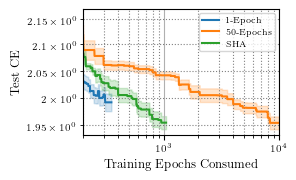

In [139]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html#lightness-of-matplotlib-colormaps
cmap = mpl.colormaps["tab10"]

plt.figure()

max_buget = 50
for i, (label, path_list) in enumerate(all_path.items()):
    color = cmap(i)
    
    default_budget = max_buget
    x_space = np.arange(1, 200 * default_budget + 1)
    df_list = map(lambda p: load_and_process(p, mode=mode, topk_tournament=3 if "CONST" in p else 1), path_list)
    x_max_i = 0
    y_list = []
    for i, df_i in enumerate(df_list):

        x = df_i["m:budget_cumsum"].to_numpy()
        x_max_i = max(x[-1], x_max_i)

        y = df_i.loc[df_i["max_idx"]]["m:objective_test"].values
        f = interp1d(x, y, kind="previous", fill_value="extrapolate")
        y = f(x_space)

        y_list.append(y)
        
    x = x_space[:x_max_i]
    y_list = np.asarray(y_list)
    y_list = y_list[:, :x_max_i]
    y_mean = y_list.mean(axis=0)
    y_stde = y_list.std(axis=0) / np.sqrt(len(y_list))

    plt.plot(x, y_mean, "-", color=color, label=stopper_label_mapping.get(label, label))
    plt.fill_between(x,
                     y_mean - y_stde,
                     y_mean + y_stde,
                     alpha=0.2,
                     color=color)
    
    # plt.axhline(y_mean[-1], linestyle="--", color=color, alpha=0.1)

plt.xlabel("Training Epochs Consumed")
plt.ylabel("Test CE")
# plt.ylabel("Objective")
plt.xscale("log")
# plt.xlim(100, 200 + 3*100)
plt.xlim(200, max_buget*200)
plt.yscale("log")
plt.grid()
plt.grid(visible=True, which="minor", color="gray", linestyle=":")
plt.legend()
plt.savefig(f"figures/pruners_{dataset}_{search}.png", bbox_inches="tight")
plt.show()

In [72]:
## Summary of Results

all_datasets = ['APSFailure', 'Amazon_employee_access', 'Australian', 'Fashion-MNIST', 'KDDCup09_appetency', 'MiniBooNE',
                'adult', 'airlines', 'albert', 'bank-marketing', 'blood-transfusion-service-center', 'car', 'christine',
                'cnae-9', 'connect-4', 'covertype', 'credit-g', 'dionis', 'fabert', 'helena', 'higgs', 'jannis', 'jasmine',
                'jungle_chess_2pcs_raw_endgame_complete', 'kc1', 'kr-vs-kp', 'mfeat-factors', 'nomao', 'numerai28.6',
                'phoneme', 'segment', 'shuttle', 'sylvine', 'vehicle', 'volkert']

mode = "min"
search = "RANDOM"
seeds = [1608637542, 3421126067, 4083286876, 787846414, 3143890026, 3348747335, 2571218620, 2563451924, 670094950, 1914837113]
pruners = ["CONST1", "NONE", "SHA"]
path = "/Users/romainegele/Documents/Argonne/deephyper-scalable-bo/experiments/local/lcbench"
max_buget = 50

results = {"dataset": []}
for pruner in pruners:
    results[f"Objective {pruner} (Mean)"] = []
    results[f"Objective {pruner} (Stde)"] = []
    results[f"Budget {pruner} (Mean)"] = []
    results[f"Budget {pruner} (Stde)"] = []

for j, dataset in enumerate(all_datasets):

    # path to experimental data
    all_path = {k:[] for k in pruners}
    for p in pruners:
        for seed in seeds:
            path_i = os.path.join(path, "output", f"{dataset}-{search}-{p}-200-{seed}", "results.csv")
            all_path[p].append(path_i)
            
    # results[dataset] = {}

    results["dataset"].append(dataset)
    
    for i, (label, path_list) in enumerate(all_path.items()):

        default_budget = max_buget
        x_space = np.arange(1, 200 * default_budget + 1)
        
        df_list = map(lambda p: load_and_process(p, mode=mode, topk_tournament=3 if "CONST" in p else 1), path_list)
        x_max_i = 0
        y_list = []
        x_max_list = []
        
        for i, df_i in enumerate(df_list):

            x = df_i["m:budget_cumsum"].to_numpy()
            x_max_i = max(x[-1], x_max_i)
            x_max_list.append(x[-1])

            y = df_i.loc[df_i["max_idx"]]["m:objective_test"].values
            f = interp1d(x, y, kind="previous", fill_value="extrapolate")
            y = f(x_space)

            y_list.append(y)

        x = x_space[:x_max_i]
        
        x_max_list = np.asarray(x_max_list)
        x_max_mean = x_max_list.mean()
        x_max_stde = x_max_list.std() / np.sqrt(len(x_max_list))
        
        y_list = np.asarray(y_list)
        y_list = y_list[:, :x_max_i]
        y_mean = y_list.mean(axis=0)
        y_stde = y_list.std(axis=0) / np.sqrt(len(y_list))
        
        results[f"Objective {label} (Mean)"].append(y_mean[-1])
        results[f"Objective {label} (Stde)"].append(y_stde[-1])
        results[f"Budget {label} (Mean)"].append(x_max_mean)
        results[f"Budget {label} (Stde)"].append(x_max_stde)

In [73]:
df = pd.DataFrame(results)
df

,dataset,Objective CONST1 (Mean),Objective CONST1 (Stde),Budget CONST1 (Mean),Budget CONST1 (Stde),Objective NONE (Mean),Objective NONE (Stde),Budget NONE (Mean),Budget NONE (Stde),Objective SHA (Mean),Objective SHA (Stde),Budget SHA (Mean),Budget SHA (Stde)
0,APSFailure,0.335644,0.003098,350.0,0.0,0.330246,0.001048,10050.0,0.0,0.333565,0.002472,817.7,31.149976
1,Amazon_employee_access,0.590910,0.002170,350.0,0.0,0.577423,0.003240,10050.0,0.0,0.578322,0.003349,843.3,48.562341
2,Australian,0.477454,0.001398,350.0,0.0,0.474990,0.001122,10050.0,0.0,0.477442,0.000742,821.9,37.940071
3,Fashion-MNIST,1.614508,0.009879,350.0,0.0,1.601960,0.003934,10050.0,0.0,1.602782,0.004164,905.1,48.217103
4,KDDCup09_appetency,0.409047,0.010067,350.0,0.0,0.371767,0.005843,10050.0,0.0,0.396476,0.008071,853.8,56.542692
5,MiniBooNE,0.441833,0.005122,350.0,0.0,0.430523,0.002565,10050.0,0.0,0.430523,0.002565,889.1,53.001406
6,adult,0.505335,0.001951,350.0,0.0,0.502276,0.000878,10050.0,0.0,0.503687,0.001245,837.9,26.627223
7,airlines,0.658292,0.000809,350.0,0.0,0.657772,0.000638,10050.0,0.0,0.657772,0.000638,891.8,47.445295
8,albert,0.641362,0.001901,350.0,0.0,0.639565,0.000732,10050.0,0.0,0.639652,0.000800,866.8,36.687273
9,bank-marketing,0.504461,0.003914,350.0,0.0,0.491918,0.002458,10050.0,0.0,0.494674,0.003431,755.0,27.648870


In [84]:
df.mean()

/var/folders/l8/8k8c8x8152zc16r3jw25gw0c0000gn/T/ipykernel_7816/3698961737.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.mean()


Objective CONST1 (Mean)        1.089011
Objective CONST1 (Stde)        0.009941
Budget CONST1 (Mean)         350.000000
Budget CONST1 (Stde)           0.000000
Objective NONE (Mean)          1.058800
Objective NONE (Stde)          0.005565
Budget NONE (Mean)         10050.000000
Budget NONE (Stde)             0.000000
Objective SHA (Mean)           1.065679
Objective SHA (Stde)           0.006592
Budget SHA (Mean)            847.800000
Budget SHA (Stde)             39.537573
dtype: float64

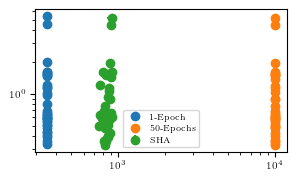

In [83]:
plt.figure()
for i, pruner in enumerate(pruners):
    plt.errorbar(
        df[f"Budget {pruner} (Mean)"], 
        df[f"Objective {pruner} (Mean)"], 
        xerr=df[f"Budget {pruner} (Stde)"], 
        yerr=df[f"Objective {pruner} (Stde)"], 
        fmt="o", 
        color=cmap(i),
        label=stopper_label_mapping.get(pruner, pruner)
    )
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [102]:
df_table = pd.DataFrame({"Dataset": [d.replace("_", " ").replace("-", " ") for d in datasets]})
df_table["1-Epoch"] = [f"{m:.2f} ± {s:.2f}" for m,s in zip(df["Objective CONST1 (Mean)"], df["Objective CONST1 (Stde)"])]
df_table["SHA"] = [f"{m:.2f} ± {s:.2f}" for m,s in zip(df["Objective SHA (Mean)"], df["Objective SHA (Stde)"])]
df_table["50-Epochs"] = [f"{m:.2f} ± {s:.2f}" for m,s in zip(df["Objective NONE (Mean)"], df["Objective NONE (Stde)"])]
df_table["S(1-Epochs)"] = (df["Budget NONE (Mean)"] / df["Budget CONST1 (Mean)"]).round(decimals=2)
df_table["S(SHA)"] = (df["Budget NONE (Mean)"] / df["Budget SHA (Mean)"]).round(decimals=2)
# df_table["Diff"] =  df["Objective SHA (Mean)"] - df["Objective CONST1 (Mean)"]
df_table.loc[10, "Dataset"] = "blood transfusion"
df_table.loc[23, "Dataset"] = "jungle chess"
df_table

,Dataset,1-Epoch,SHA,50-Epochs,S(1-Epochs),S(SHA)
0,APSFailure,0.34 ± 0.00,0.33 ± 0.00,0.33 ± 0.00,28.71,12.29
1,Amazon employee access,0.59 ± 0.00,0.58 ± 0.00,0.58 ± 0.00,28.71,11.92
2,Australian,0.48 ± 0.00,0.48 ± 0.00,0.47 ± 0.00,28.71,12.23
3,Fashion MNIST,1.61 ± 0.01,1.60 ± 0.00,1.60 ± 0.00,28.71,11.10
4,KDDCup09 appetency,0.41 ± 0.01,0.40 ± 0.01,0.37 ± 0.01,28.71,11.77
5,MiniBooNE,0.44 ± 0.01,0.43 ± 0.00,0.43 ± 0.00,28.71,11.30
6,adult,0.51 ± 0.00,0.50 ± 0.00,0.50 ± 0.00,28.71,11.99
7,airlines,0.66 ± 0.00,0.66 ± 0.00,0.66 ± 0.00,28.71,11.27
8,albert,0.64 ± 0.00,0.64 ± 0.00,0.64 ± 0.00,28.71,11.59
9,bank marketing,0.50 ± 0.00,0.49 ± 0.00,0.49 ± 0.00,28.71,13.31


In [103]:
print(df_table.to_latex(index=False))

\begin{tabular}{llllrr}
\toprule
               Dataset &     1-Epoch &         SHA &   50-Epochs &  S(1-Epochs) &  S(SHA) \\
\midrule
            APSFailure & 0.34 ± 0.00 & 0.33 ± 0.00 & 0.33 ± 0.00 &        28.71 &   12.29 \\
Amazon employee access & 0.59 ± 0.00 & 0.58 ± 0.00 & 0.58 ± 0.00 &        28.71 &   11.92 \\
            Australian & 0.48 ± 0.00 & 0.48 ± 0.00 & 0.47 ± 0.00 &        28.71 &   12.23 \\
         Fashion MNIST & 1.61 ± 0.01 & 1.60 ± 0.00 & 1.60 ± 0.00 &        28.71 &   11.10 \\
    KDDCup09 appetency & 0.41 ± 0.01 & 0.40 ± 0.01 & 0.37 ± 0.01 &        28.71 &   11.77 \\
             MiniBooNE & 0.44 ± 0.01 & 0.43 ± 0.00 & 0.43 ± 0.00 &        28.71 &   11.30 \\
                 adult & 0.51 ± 0.00 & 0.50 ± 0.00 & 0.50 ± 0.00 &        28.71 &   11.99 \\
              airlines & 0.66 ± 0.00 & 0.66 ± 0.00 & 0.66 ± 0.00 &        28.71 &   11.27 \\
                albert & 0.64 ± 0.00 & 0.64 ± 0.00 & 0.64 ± 0.00 &        28.71 &   11.59 \\
        bank marketing & 0.5

In [35]:
text = r"""
    \begin{subfigure}[b]{0.24\textwidth}
        \centering
        \includegraphics[width=\textwidth]{figures/lcbench/searches/pruners_XXX_RANDOM.png}
        \caption{YYY}
        \label{fig:pruners-XXX-lcbench}
    \end{subfigure}"""

In [37]:
for dataset in all_datasets:
    print(text.replace("XXX", dataset).replace("YYY", dataset.replace("_", " ").replace("-", " ")), end="")


    \begin{subfigure}[b]{0.24\textwidth}
        \centering
        \includegraphics[width=\textwidth]{figures/lcbench/searches/pruners_APSFailure_RANDOM.png}
        \caption{APSFailure}
        \label{fig:pruners-APSFailure-lcbench}
    \end{subfigure}
    \begin{subfigure}[b]{0.24\textwidth}
        \centering
        \includegraphics[width=\textwidth]{figures/lcbench/searches/pruners_Amazon_employee_access_RANDOM.png}
        \caption{Amazon employee access}
        \label{fig:pruners-Amazon_employee_access-lcbench}
    \end{subfigure}
    \begin{subfigure}[b]{0.24\textwidth}
        \centering
        \includegraphics[width=\textwidth]{figures/lcbench/searches/pruners_Australian_RANDOM.png}
        \caption{Australian}
        \label{fig:pruners-Australian-lcbench}
    \end{subfigure}
    \begin{subfigure}[b]{0.24\textwidth}
        \centering
        \includegraphics[width=\textwidth]{figures/lcbench/searches/pruners_Fashion-MNIST_RANDOM.png}
        \caption{Fashion MNIST}
    